# XGBoost(eXtra Gradient Boost)
다른 알고리즘보다 뛰어난 예측 성능
GBM 실행 시간 개선(병렬 학습 가능), 과적합 규제 (Regularization) 부재 문제 해결
- 과적합 규제?
    - 모델의 복잡도를 줄여서 일반화 성능 향상
    - 모델의 과적합을 막고자 함

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

## XGBoost hyper parameter
- 일반 파라미터: 기본 설정 (거의 바꾸는 일이 없음)
    - booster: gbtree(default, tree based model), gblinear(linear model)
    - silent: console log toggle
    - nthread: CPU thread control (default: use all CPU)
- 주요 부스터 파라미터: 트리 최적화, boosting, regularization
    - eta \[default=0.3, alias: learning_rate]: boosting step learning rate (default: 0.1, 0.01 ~ 0.2 preferred)
    - num_boost_rounds: n_estimators (amounts)
    - min_child_weight\[default=1]: data weight sum (tree branch check - prevents overfitting)
    - gamma \[default=0, alias: min_split_loss\]: loss minimum value
    - max_depth \[default=6]: if zero, no depth limit (3~10 recommended)
    - sub_sample \[default=1]: data sampling rate
    - colsample_bytree \[default=1]: max_features, feature sampling
    - lambda \[default=1, alias: reg_lambda]: L2 Regularization
        - L2 규제: 가중치의 제곱에 비례하는 페널티를 추가하여 가중치의 크기를 제한
    - alpha \[default=0, alias: reg_alpha]: L1 Regularization
        - L1 규제: 가중치의 절대값에 비례하는 페널티를 추가하여 가중치의 크기를 제한
    - scale_pos_weight \[default=1]: to adjust data set balance
- 학습 태스크 파라미터: object function, evaluation
    - objective: loss function
    - binary:logistic: binary
    - multi:softmax: multi classification
    - multi:softprob: multi:softmax but returns each label class' prediction rate
    - eval_metric: function to use in validation

to prevent overfitting
- downsize eta value -> upsize num_round (or estimators)
- downsize max_depth
- upsize min_child_weight
- upsize gamma
- adjust subsample, colsample_bytree

In [2]:
import xgboost
print(xgboost.__version__)

1.7.4


## Breast Cancer prediction (using XGBoost)

In [4]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df["target"] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
print(dataset.target_names)
print(cancer_df["target"].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [11]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


XGBoost uses DMatrix

In [12]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
d_val = xgb.DMatrix(data=X_val, label=y_val)
d_test = xgb.DMatrix(data=X_test, label=y_test)

In [13]:
params = {
    "max_depth": 3, # tree max depth
    "eta": 0.05, # learning rate
    "objective": "binary:logistic", # binary
    "eval_metric": "logloss", # validation
}
num_rounds = 400

조기 중단 (early_stopping_rounds)
- 지표의 개선이 없을 경우에 중간에 반복을 빠져 나옴
- 조기 중단 가능 판단까지의 최소 반복 횟수 설정
- train data set 설정, eval_metric parameter 설정

In [14]:
eval_list = [(dtr, "train"), (d_val, "eval")]
# eval_list = [(d_val, "eval")] 도 가능

xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

after 126th eval-logloss, there are no improvements, so stop at 176th.

In [15]:
prd_probs = xgb_model.predict(d_test)
print("predict() result head of 10")
print(np.round(prd_probs[:10], 3))

prds = [1 if x > 0.5 else 0 for x in prd_probs]
print("10 predictions", prds[:10])

predict() result head of 10
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
10 predictions [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("confusion matrix: \n", confusion)
    print("accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, ROC-AUC: {4:.4f}"
          .format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, prds, prd_probs)

confusion matrix: 
 [[34  3]
 [ 2 75]]
accuracy: 0.9561, precision: 0.9615, recall: 0.9740, f1: 0.9677, ROC-AUC: 0.9937


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

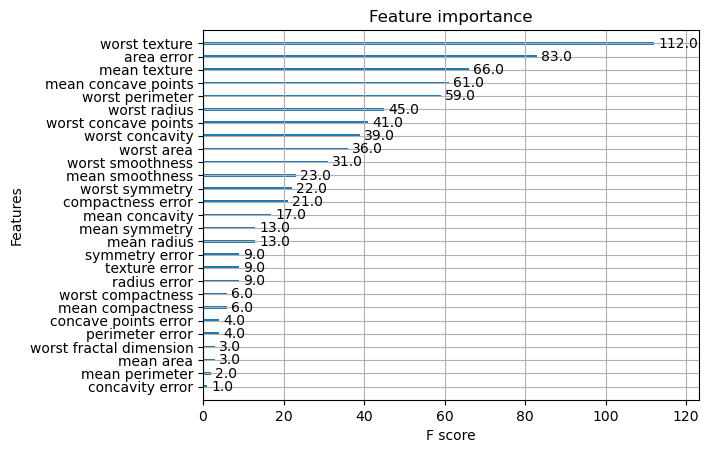

In [18]:
plot_importance(xgb_model)

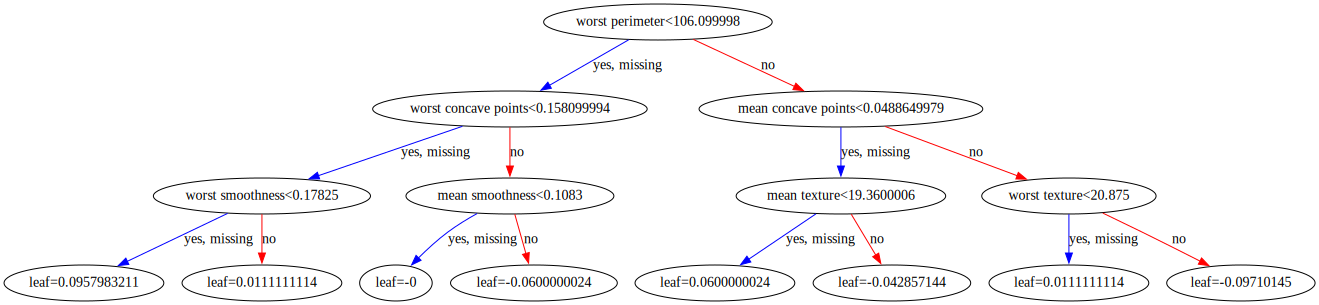

In [19]:
xgboost.to_graphviz(xgb_model)

XGBoost can also do cv(Cross Validation)

## Scikit Learn Wrapper XGBoost
some slight changes
eta -> learning_rate
sub_sample -> subsample
lambda -> reg_lambda
alpha -> reg_alpha

In [20]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3,
                            eval_metric="logloss")
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_prds = xgb_wrapper.predict(X_test)
w_prd_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [21]:
get_clf_eval(y_test, w_prds, w_prd_proba)

confusion matrix: 
 [[34  3]
 [ 1 76]]
accuracy: 0.9649, precision: 0.9620, recall: 0.9870, f1: 0.9744, ROC-AUC: 0.9954


In [22]:
# early stopping rounds in Scikit Learn wrapper

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss",
                eval_set=evals, verbose=True)

ws50_prds = xgb_wrapper.predict(X_test)
ws50_prd_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [23]:
get_clf_eval(y_test, ws50_prds, ws50_prd_proba)

confusion matrix: 
 [[34  3]
 [ 2 75]]
accuracy: 0.9561, precision: 0.9615, recall: 0.9740, f1: 0.9677, ROC-AUC: 0.9933


In [24]:
# If early stopping rounds set to 10?

xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric="logloss",
                eval_set=evals, verbose=True)

ws10_prds = xgb_wrapper.predict(X_test)
ws10_prd_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, ws10_prds, ws10_prd_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

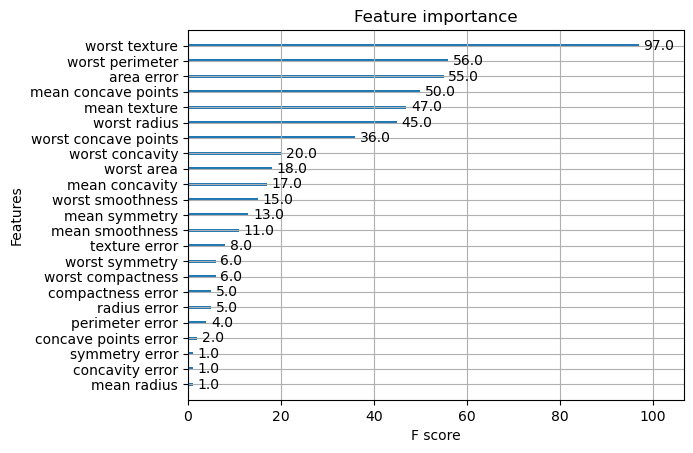

In [25]:
plot_importance(xgb_wrapper)